In [1]:
import torch
import torch.nn as nn
import zuko

from lampe.plots import corner
from torch import Tensor
from typing import *
from zuko.utils import broadcast

from priors.nn import MLP
from priors.score import *

## Data

In [2]:
domain = -3.0 * torch.ones(10), 3.0 * torch.ones(10)

def generate(n: int) -> Tensor:    
    return torch.sort(torch.randn(n, 10), dim=-1).values

def linear(A: Tensor, x: Tensor):
    return torch.einsum('...ij,...j->...i', A, x)

x = generate(16384).cuda()
A = torch.randn(16384, 3, 10).cuda() / 10 ** 0.5
y = torch.normal(linear(A, x), 1e-2)

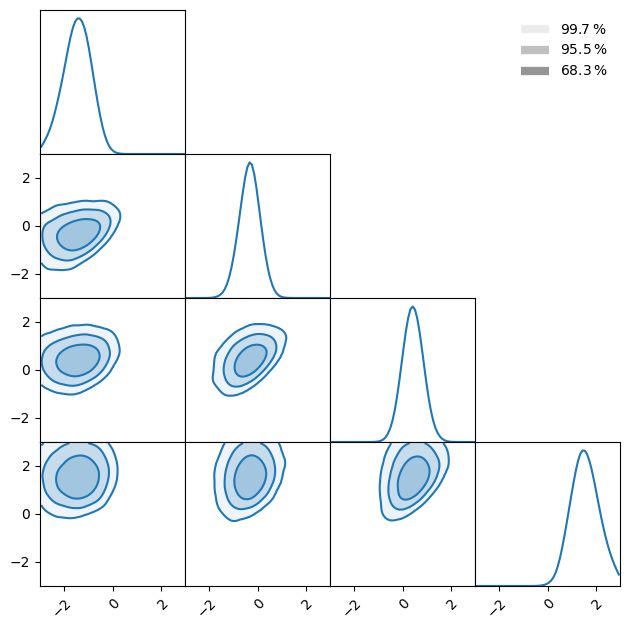

In [3]:
fig = corner(x[..., ::3].cpu(), domain=domain, smooth=2)

100%|██████████| 256/256 [00:00<00:00, 339.59it/s]


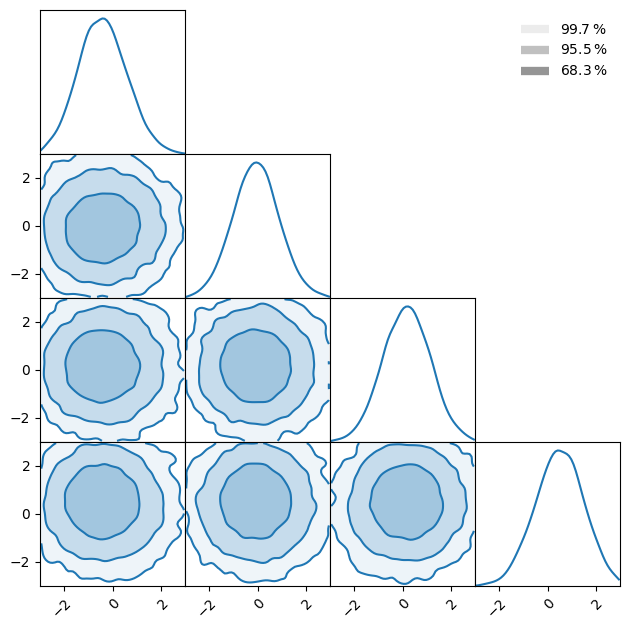

In [4]:
def sample(model, A, y):
    sde = ReverseSDE(
        PosteriorScoreModel(
            model=model,
            y=y,
            A=lambda x: linear(A, x),
            noise=1e-2,
            gamma=1.0,
        )
    ).cuda()

    z = torch.randn_like(linear(A.mT, y))
    x_bis = sde(z, steps=256, corrections=1, tau=0.25)

    return x_bis

x_bis = sample(StandardScoreModel(), A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

## Training

In [5]:
class ScoreModel(nn.Module):
    def __init__(self, features: int, **kwargs):
        super().__init__()

        self.embedding = TimeEmbedding(16)
        self.net = MLP(features + 16, features, **kwargs)

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        t = self.embedding(t)
        x = torch.cat(broadcast(x, t, ignore=1), dim=-1)

        return self.net(x)

In [6]:
def train(x, A, y):
    sde = VPSDE()
    model = ScoreModel(10, hidden_features=[256, 256], normalize=True).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, 8192)

    for step in range(8192):
        i = torch.randint(0, len(x), (256,)).cuda()
        xi = x[i]
        Ai = A[i]

        t = torch.rand_like(xi[..., 0])
        xi, z = sde(xi, t)

        loss = linear(Ai, model(xi, t) - z).square().mean()
        loss.backward()

        if step % 1024 == 0:
            print(f'({step})', loss.item())

        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step()

    return model

(0) 1.14496648311615
(1024) 0.23000852763652802
(2048) 0.29688140749931335
(3072) 0.201992005109787
(4096) 0.23457446694374084
(5120) 0.22944794595241547
(6144) 0.23231308162212372
(7168) 0.2261999100446701


100%|██████████| 256/256 [00:02<00:00, 104.10it/s]


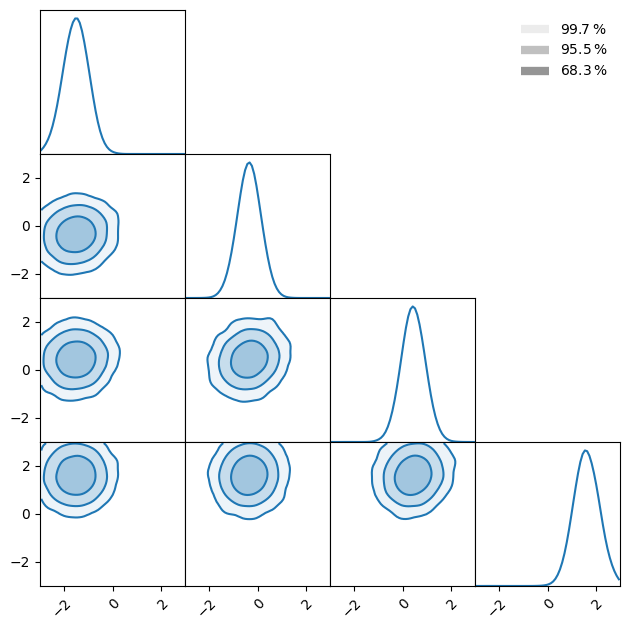

In [7]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

(0) 1.5638058185577393
(1024) 0.23819927871227264
(2048) 0.17474699020385742
(3072) 0.21023236215114594
(4096) 0.21918317675590515
(5120) 0.20323120057582855
(6144) 0.2690020203590393
(7168) 0.26357802748680115


100%|██████████| 256/256 [00:02<00:00, 106.52it/s]


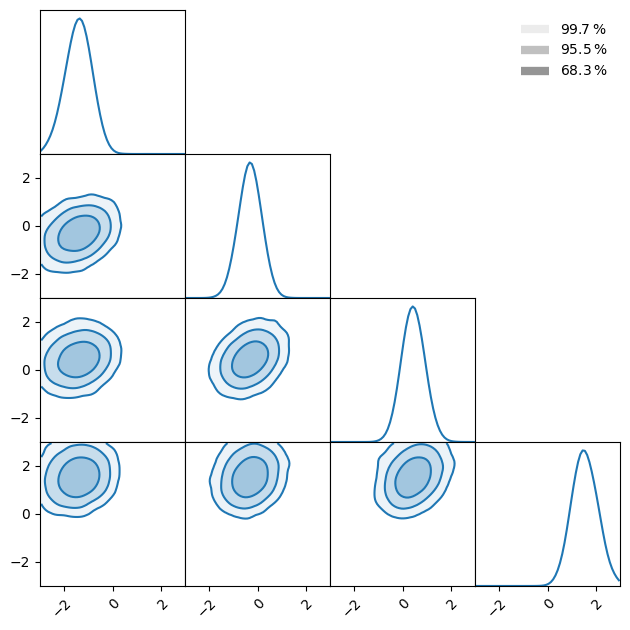

In [8]:
model = train(x_bis, A, y)
x_bis = sample(model, A, y)
fig = corner(x_bis[..., ::3].cpu(), domain=domain, smooth=2)

100%|██████████| 256/256 [00:00<00:00, 375.06it/s]


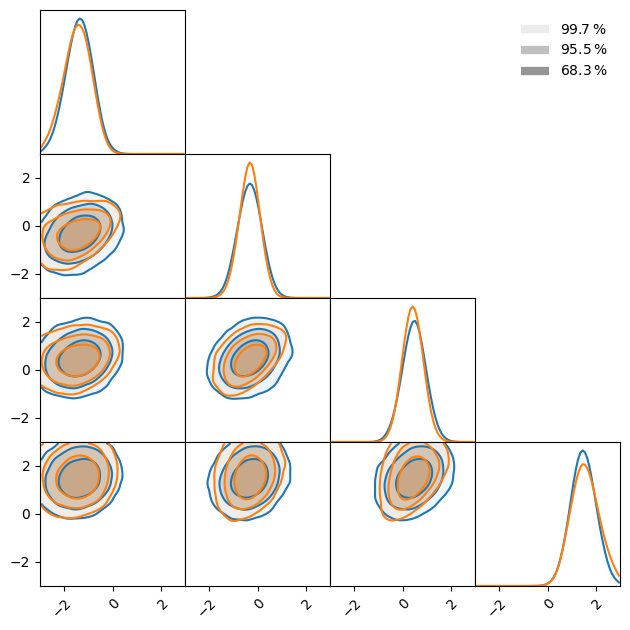

In [9]:
sde = ReverseSDE(model)

z = torch.randn_like(x)
x_ter = sde(z, steps=256, corrections=1, tau=0.25)

fig = corner(x_ter[..., ::3].cpu(), domain=domain, smooth=2)
fig = corner(x[..., ::3].cpu(), domain=domain, smooth=2, figure=fig)